In [1]:
import os

# Disable GPU usage
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Using CPU for processing")


Using CPU for processing


Image IMG_8351.JPEG: Detected 1 faces
Image IMG_0070.JPEG: Detected 3 faces
Image IMG_4627.JPEG: Detected 2 faces
Image IMG_1852.JPEG: Detected 1 faces
Image IMG_9987.JPEG: Detected 1 faces
Image IMG_1465.JPEG: Detected 1 faces
Image IMG_6954.JPEG: Detected 2 faces
Image IMG_0910.JPEG: Detected 2 faces
Image IMG_2503.JPEG: Detected 2 faces
Image IMG_1305.JPEG: Detected 1 faces
Image IMG_8337.JPEG: Detected 2 faces
Image IMG_0213.JPEG: Detected 2 faces
Image IMG_8390.JPEG: Detected 1 faces
Image IMG_2766.JPEG: Detected 2 faces
Image IMG_1326.JPEG: Detected 2 faces
Image IMG_4566.JPEG: Detected 5 faces
Image IMG_0858.JPEG: Detected 6 faces
Image IMG_6892.JPEG: Detected 2 faces
Image IMG_2065.JPEG: Detected 3 faces
Image 94243F78-9C53-41A4-B721-B092318BC2A0.JPG: Detected 0 faces
Image IMG_2258.JPEG: Detected 5 faces
Image IMG_7099.JPEG: Detected 3 faces
Image IMG_9959.JPEG: Detected 1 faces
Image IMG_8341.JPEG: Detected 2 faces
Image IMG_9313.JPEG: Detected 1 faces
Image IMG_1315.JPEG: De

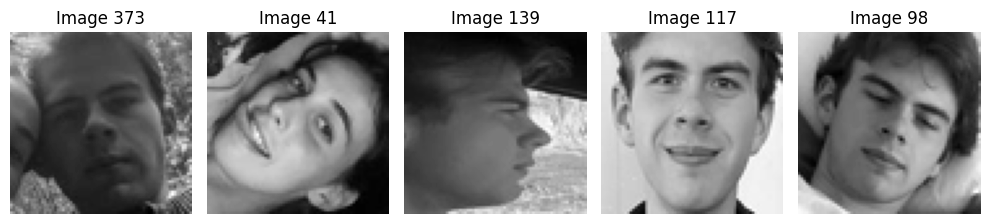

In [6]:
from mtcnn import MTCNN
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

detector = MTCNN()


# Paths
cascade_path = "/home/chris/Desktop/itba/2024C2/sia/tps/sia/tp5/haarcascade_frontalface_default.xml"  # Path to Haar cascade XML file
os.makedirs("/home/chris/Desktop/itba/2024C2/sia/tps/sia/tp5/data/cropped_faces", exist_ok=True)  # Directory for cropped faces

# Load Haar cascade for face detection
def crop_faces(input_dir, output_dir, margin=0.2, output_size=128, max_faces=5):
    """
    Detects and crops faces using MTCNN from images in the input directory with optional margin,
    ensuring the cropped face is a square and resizing to the specified output size.
    """
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(input_dir, filename)
            img = Image.open(img_path)

            # Resize the image to reduce computational load
            MAX_SIZE = (800, 800)  # Adjust this as needed

            # Use Image.LANCZOS instead of Image.ANTIALIAS
            img.thumbnail(MAX_SIZE, Image.LANCZOS)
            img_array = np.asarray(img)

            # Detect faces
            faces = detector.detect_faces(img_array)

            print(f"Image {filename}: Detected {len(faces)} faces")

            for i, face in enumerate(faces[:max_faces]):  # Process up to max_faces
                x, y, w, h = face['box']

                # Calculate the center of the bounding box
                center_x = x + w // 2
                center_y = y + h // 2

                # Make the bounding box square
                max_dim = max(w, h)
                max_dim_margin = int(max_dim * (1 + margin))

                # Calculate square bounding box coordinates
                x_start = max(center_x - max_dim_margin // 2, 0)
                y_start = max(center_y - max_dim_margin // 2, 0)
                x_end = min(center_x + max_dim_margin // 2, img_array.shape[1])
                y_end = min(center_y + max_dim_margin // 2, img_array.shape[0])

                # Crop the face
                face_image = img_array[y_start:y_end, x_start:x_end]

                # Resize to the desired output size
                pil_image = Image.fromarray(face_image).resize((output_size, output_size), Image.LANCZOS)

                # Save the processed image
                face_filename = f"{os.path.splitext(filename)[0]}_face_{i}.jpg"
                pil_image.save(os.path.join(output_dir, face_filename))

    print(f"Faces cropped to squares and saved in {output_dir}")


def image_to_bw_matrix(image_path, n):
    """
    Loads an image, converts it to black and white, resizes it to nxn, and returns
    a numpy array with values between 0 and 1.
    """
    # Open the image and convert to grayscale
    img = Image.open(image_path).convert('L')
    # Resize the image to nxn pixels
    img = img.resize((n, n))
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Normalize the pixel values between 0 and 1
    img_array = img_array.astype('float32') / 255.0
    return img_array

def process_images_in_directory(directory_path, n, show_intermediate=False):
    """
    Processes all images in the given directory, converts them to black and white nxn images,
    and returns a list of numpy arrays. Optionally displays the intermediate black-and-white images.
    
    Args:
        directory_path (str): Path to the directory containing images.
        n (int): Desired size of the reduced image (n x n).
        show_intermediate (bool): If True, displays the intermediate images.
        
    Returns:
        list: A list of numpy arrays representing the processed images.
    """
    image_arrays = []
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(directory_path, filename)
            img_array = image_to_bw_matrix(image_path, n)
            image_arrays.append(img_array)

            if show_intermediate:
                # Show the processed image
                plt.figure()
                plt.imshow(img_array, cmap="gray")
                plt.title(f"Processed: {filename}")
                plt.axis("off")
                plt.show()
                
    return image_arrays

def prepare_image_data(directory_path, n, test_split=0.0, show_intermediate=False):
    """
    Processes images in the given directory, converts them to black and white nxn images,
    and prepares training and test data in the required format.
    
    Args:
        directory_path (str): Path to the directory containing images.
        n (int): Desired size of the reduced image (n x n).
        test_split (float): Fraction of data to use as the test set.
        show_intermediate (bool): If True, shows intermediate black-and-white images.
        
    Returns:
        tuple: Training data, test data, and visual data for visualization.
    """
    print("Processing images...")
    image_arrays = process_images_in_directory(directory_path, n, show_intermediate)
    image_arrays = np.array(image_arrays)
    
    # For visualization purposes
    x_visual = image_arrays.astype('float32')

    # Reshape images for training
    num_images = image_arrays.shape[0]
    x_data = image_arrays.reshape(num_images, -1).astype('float32')

    # Split into training and test sets
    split_index = int(num_images * (1 - test_split))
    x_train = x_data[:split_index]
    x_test = x_data[split_index:]
    x_visual_train = x_visual[:split_index]

    # Create training and test pairs for unsupervised learning
    training_data = [(x.reshape(-1, 1), x.reshape(-1, 1)) for x in x_train]
    test_data = [(x.reshape(-1, 1), x.reshape(-1, 1)) for x in x_test]

    return training_data, test_data, x_visual_train

def show_images(images, num_samples=3):
    """
    Displays a specified number of images from the processed dataset.
    
    Args:
        images (numpy.ndarray): Array of images to display.
        num_samples (int): Number of images to display.
    """
    random_indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.title(f"Image {idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
input_dir = '/home/chris/Desktop/itba/2024C2/sia/tps/sia/tp5/data/iCloud Photos'  # Directory with raw iPhone photos
cropped_dir = '/home/chris/Desktop/itba/2024C2/sia/tps/sia/tp5/data/cropped_faces'       # Directory for cropped face images
n = 70                              # Desired image size for the VAE

# Step 1: Crop faces and save to 'cropped_faces'
crop_faces(input_dir, cropped_dir, 0.2)

# Step 2: Process and prepare data for VAE
training_data, test_data, x_visual = prepare_image_data(cropped_dir, n, test_split=0.0, show_intermediate=False)

# Step 3: Show some sample images
show_images(x_visual, num_samples=5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from core.activation_function import ActivationFunction
from core.optimizer import Optimizer
from core.vae import VAE

# Latent space dimensions
latent_dim = 64

# Encoder and decoder topologies based on the input image size
input_size = x_visual.shape[1] * x_visual.shape[2]  # Flattened size of input images
print(input_size)
encoder_topology = [input_size, input_size, 1000, 500, 64, 2 * latent_dim]
decoder_topology = [latent_dim, 64, 500, 1000, input_size, input_size]

# Configure optimizers
encoder_optimizer = Optimizer(method="adam", eta=0.01)
decoder_optimizer = Optimizer(method="adam", eta=0.01)

# Configure the activation function
activation_function = ActivationFunction(method="relu")

# Initialize the VAE model
vae = VAE(
    seed=42,
    encoder_topology=encoder_topology,
    decoder_topology=decoder_topology,
    activation_function=activation_function,
    encoder_optimizer=encoder_optimizer,
    decoder_optimizer=decoder_optimizer
)

# Train the VAE
vae.fit(
    training_data=training_data,  # Use the training data prepared earlier
    epochs=500,
    mini_batch_size=32
)



4900


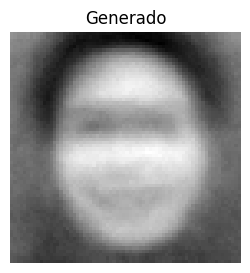

In [39]:
# Generar una nueva imagen aleatoria desde el espacio latente
z_random = np.random.normal(size=(vae.latent_dim, 1))  # Vector aleatorio en el espacio latente
generated_x, _, _ = vae.decode(z_random)  # Decodificar desde el vector latente

# Visualizar la imagen generada
plt.figure(figsize=(3, 3))
plt.imshow(generated_x.reshape(x_visual.shape[1], x_visual.shape[2]), cmap="gray")
plt.title("Generado")
plt.axis("off")
plt.show()


In [ ]:
# Select two random latent vectors
z1 = np.random.normal(size=(vae.latent_dim, 1))
z2 = np.random.normal(size=(vae.latent_dim, 1))

# Number of interpolation steps
steps = 10
interpolated_images = []

# Interpolate between z1 and z2
for alpha in np.linspace(0, 1, steps):
    z_interp = alpha * z1 + (1 - alpha) * z2
    generated_x, _, _ = vae.decode(z_interp)
    interpolated_images.append(generated_x)

# Visualize the interpolated images
plt.figure(figsize=(15, 3))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, steps, i + 1)
    plt.imshow(img.reshape(x_visual.shape[1], x_visual.shape[2]), cmap="gray")
    plt.axis("off")
    plt.title(f"Step {i+1}")
plt.tight_layout()
plt.show()


In [ ]:
# Start with a random latent vector
z = np.random.normal(size=(vae.latent_dim, 1))

# Manipulate a specific dimension
z[2] += 3.0  # Example: Increase the 3rd latent dimension
generated_x, _, _ = vae.decode(z)

# Visualize the manipulated image
plt.figure(figsize=(3, 3))
plt.imshow(generated_x.reshape(x_visual.shape[1], x_visual.shape[2]), cmap="gray")
plt.title("Latent Dimension Manipulation")
plt.axis("off")
plt.show()


In [ ]:
# Example: Add a one-hot encoded label vector
label = np.zeros((10, 1))  # Assume 10 possible labels
label[2] = 1  # Condition on label "2"

# Concatenate latent vector with label
z_conditional = np.concatenate([np.random.normal(size=(vae.latent_dim - 10, 1)), label])
generated_x, _, _ = vae.decode(z_conditional)

# Visualize the conditioned image
plt.figure(figsize=(3, 3))
plt.imshow(generated_x.reshape(x_visual.shape[1], x_visual.shape[2]), cmap="gray")
plt.title("Conditioned Generation")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def interpolate_faces(vae, face1, face2, steps=10):
    """
    Interpolates between two input faces in the latent space of a VAE.

    Args:
        vae (VAE): Trained Variational Autoencoder.
        face1 (np.ndarray): First face, flattened and normalized.
        face2 (np.ndarray): Second face, flattened and normalized.
        steps (int): Number of interpolation steps.

    Returns:
        list: Decoded images corresponding to the interpolated latent vectors.
    """
    # Encode the two faces to obtain their latent representations
    _, _, z1, _, _, _, _, _, _ = vae.feedforward(face1)
    _, _, z2, _, _, _, _, _, _ = vae.feedforward(face2)

    # Interpolate between the two latent vectors
    interpolated_faces = []
    for alpha in np.linspace(0, 1, steps):
        z_interp = alpha * z1 + (1 - alpha) * z2
        generated_face, _, _ = vae.decode(z_interp)
        interpolated_faces.append(generated_face)

    return interpolated_faces

# Example Usage
# Select two faces from the dataset
face1, _ = training_data[0]  # First test face
face2, _ = training_data[2]  # Second test face

# Interpolate between the two faces
steps = 10  # Number of steps in the interpolation
interpolated_faces = interpolate_faces(vae, face1, face2, steps)

# Visualize the original faces and interpolation
plt.figure(figsize=(15, 3))

# Show the first face
plt.subplot(1, steps + 2, 1)  # Adding 2 for the original faces
plt.imshow(face1.reshape(x_visual.shape[1], x_visual.shape[2]), cmap="gray")
plt.title("Face 1")
plt.axis("off")

# Show interpolated faces
for i, face in enumerate(interpolated_faces):
    plt.subplot(1, steps + 2, i + 2)
    plt.imshow(face.reshape(x_visual.shape[1], x_visual.shape[2]), cmap="gray")
    plt.axis("off")
    plt.title(f"Step {i+1}")

# Show the second face
plt.subplot(1, steps + 2, steps + 2)
plt.imshow(face2.reshape(x_visual.shape[1], x_visual.shape[2]), cmap="gray")
plt.title("Face 2")
plt.axis("off")

plt.tight_layout()
plt.show()
